Arecanut disease detection using Machine learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
tf.__version__

'2.18.0'

In [5]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=16
)

Found 723 files belonging to 5 classes.


In [7]:
class_names = dataset.class_names
class_names

['Chukki_roga_Pathogen1',
 'Chukki_roga_Pathogen2',
 'Chukki_roga_Pathogen3',
 'Kole_roga',
 'healthy']

In [8]:
n_classes = len(class_names)
n_classes

5

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[4 1 1 0 3 1 0 0 1 1 3 0 2 4 4 3]


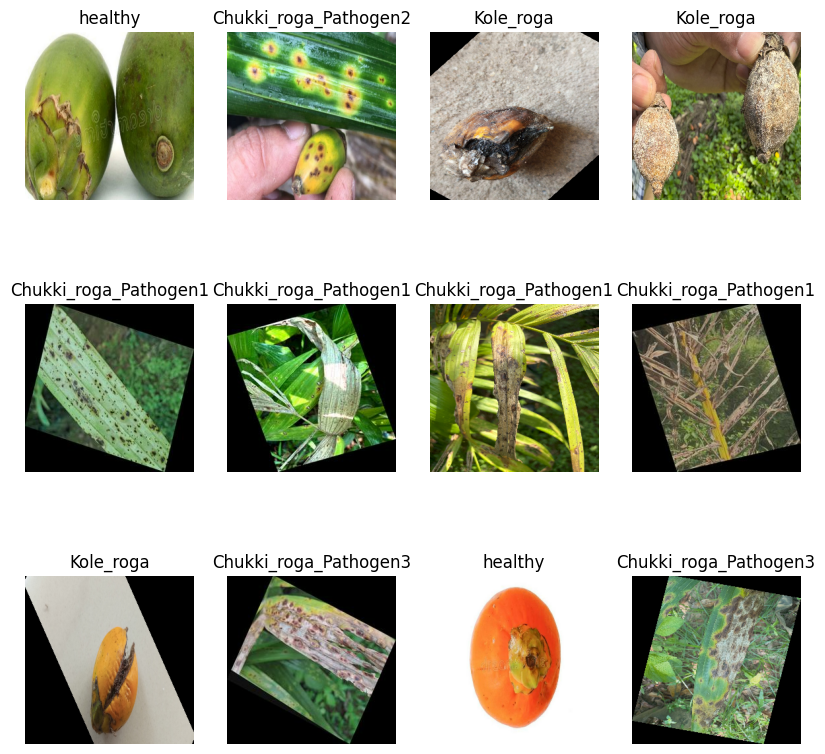

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

46

80% ==> training ,
20% ==> 10% validation, 10% test

In [12]:
train_size = 0.8
len(dataset)*train_size

36.800000000000004

In [13]:
train_ds = dataset.take(30)
len(train_ds)

30

In [14]:
test_ds = dataset.skip(30)
len(test_ds)

16

In [15]:
val_size=0.1
len(dataset)*val_size

4.6000000000000005

In [16]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [17]:
test_ds = test_ds.skip(4)
len(test_ds)

12

The same implementation in a nice way of python function is given below:

In [18]:
def get_dataset_partiton_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=5000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partiton_tf(dataset)

In [20]:
len(train_ds)

36

In [21]:
len(val_ds)

4

In [22]:
len(test_ds)

6

1. Prefetching:
Prefetching refers to loading data into memory ahead of time, allowing the model to be trained on the data while the next batch is being prepared. This helps to ensure that the GPU/CPU is always working on the next batch of data without waiting for the input pipeline to load it.

You can use TensorFlow's tf.data.Dataset.prefetch method to enable prefetching.

2. Caching:
Caching is used to store the dataset in memory after the first epoch, so subsequent epochs do not need to read the data from disk again, significantly speeding up training when working with smaller datasets that fit into memory.

You can use tf.data.Dataset.cache() to cache the data.

This can optimize the function of reading the dataset.

In [23]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size = tf.data.AUTOTUNE)

We will resize and rescale the images using "layers.Resizing()" and "layers.Rescaling()" .

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

We will do Data-Augmentation to make the model look more robust.

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2),
])

Building a Model using Convolutional Neural Networks.

In [26]:
input_shape = (BATCH_SIZE, 256, 256, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (16, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (16, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (16, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (16, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (16, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (16, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (16, 115200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 128)                   │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (16, 5)                     │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,621 (56.61 MB)

 Trainable params: 14,839,621 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 517ms/step - accuracy: 0.2642 - loss: 2.8453 - val_accuracy: 0.7031 - val_loss: 1.1658
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 444ms/step - accuracy: 0.5986 - loss: 1.1284 - val_accuracy: 0.6250 - val_loss: 1.0003
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 441ms/step - accuracy: 0.6912 - loss: 0.9359 - val_accuracy: 0.7656 - val_loss: 0.7559
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 440ms/step - accuracy: 0.7200 - loss: 0.8633 - val_accuracy: 0.6562 - val_loss: 0.7567
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step - accuracy: 0.7454 - loss: 0.8304 - val_accuracy: 0.7969 - val_loss: 0.7487
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 442ms/step - accuracy: 0.7086 - loss: 0.7738 - val_accuracy: 0.7969 - val_loss: 0.6483
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.8156 - loss: 0.6363 - val_accuracy: 0.7188 - val_loss: 0.8454
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 441ms/step - accuracy: 0.7671 - loss: 0.7004 - val_accu

In [30]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9179 - loss: 0.4933


In [31]:
scores

[0.5071671605110168, 0.9270833134651184]

In [32]:












history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 36}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

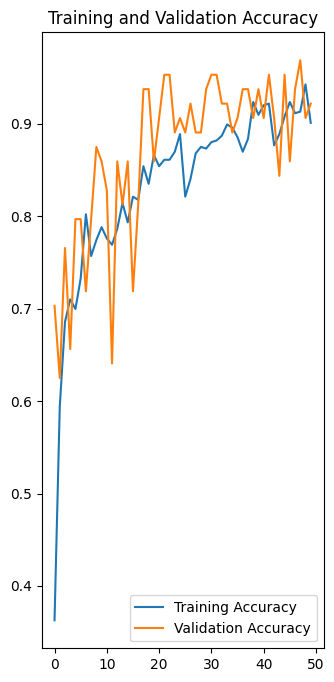

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

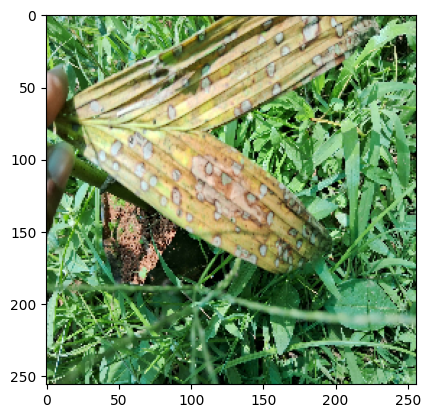

In [37]:
for images_batch, labels_batch in test_ds.take(1):

    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [38]:
import numpy as np

first image to predict
actual label: Chukki_roga_Pathogen1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
[8.7130189e-01 1.2868258e-01 4.7940389e-06 4.5053698e-06 6.2080899e-06]
Predicted label: Chukki_roga_Pathogen1


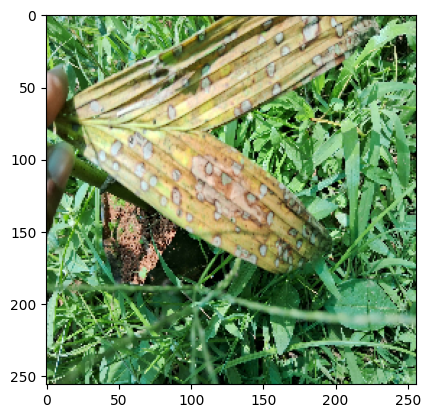

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


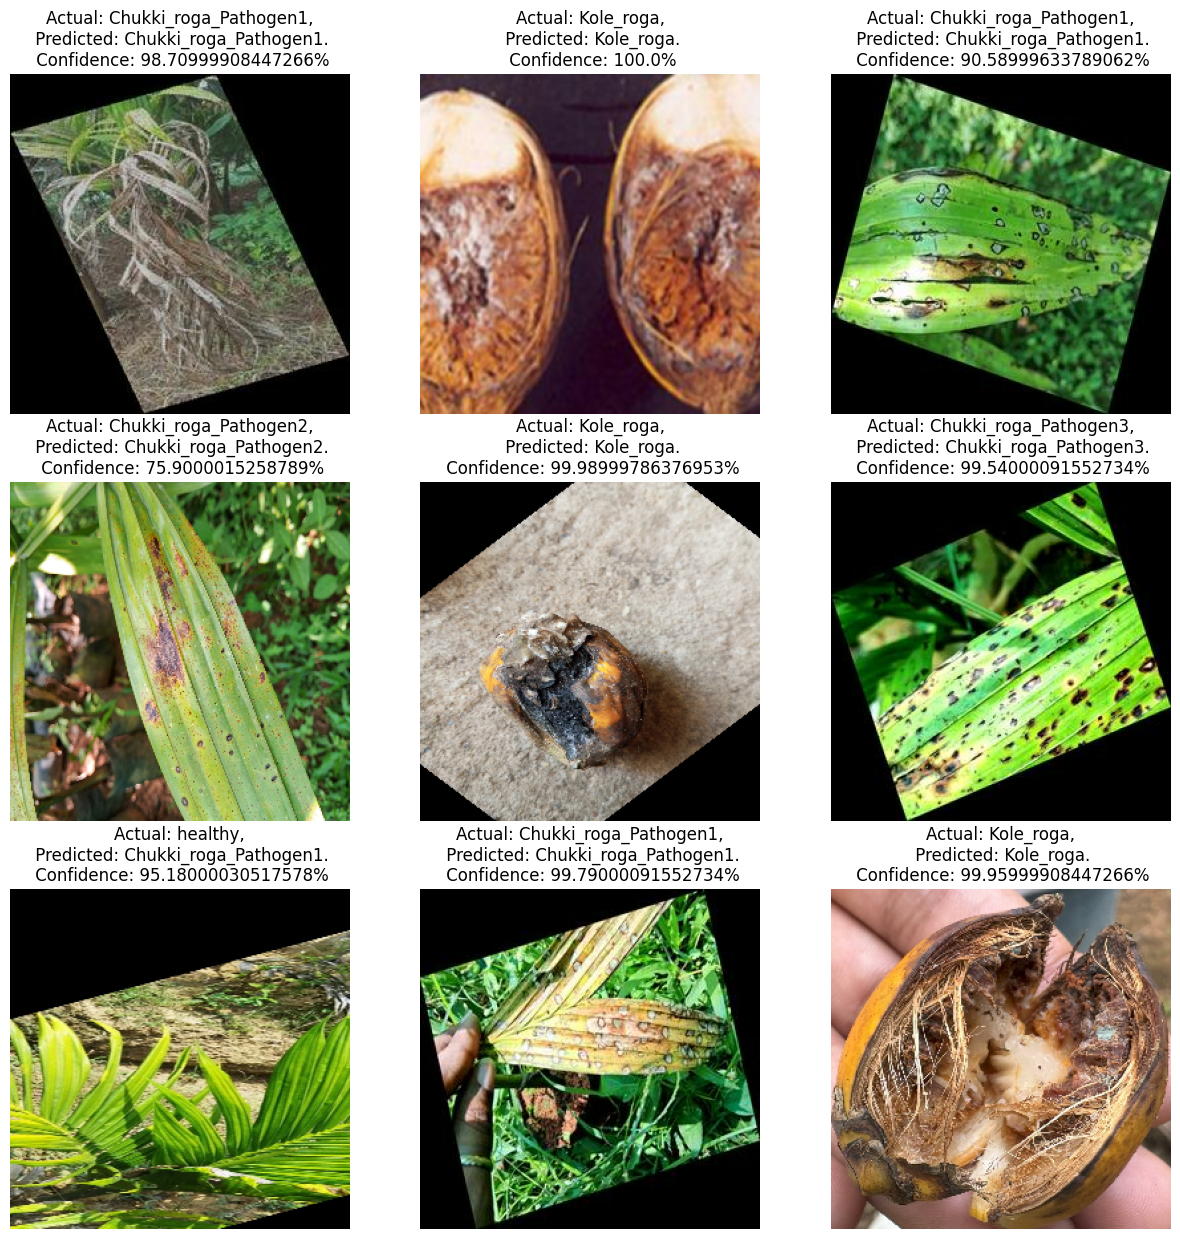

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
model_version=1
model.save(f"E:/mini project/models/{model_version}.keras")
